In [19]:
!pip install console-progressbar

  Created wheel for console-progressbar: filename=console_progressbar-1.1.2-py3-none-any.whl size=4144 sha256=587ff3d6c03b5699adc8cf127c7a10f54b4f716f36ecb31d5a0e0e4faf23734f
  Stored in directory: c:\users\99555\appdata\local\pip\cache\wheels\87\c7\73\c11410f76f8c24639489b8bfc441ff949f3fceee3318493f3e
Successfully built console-progressbar


In [65]:
import numpy as np
import scipy.io as sio 
import os
import cv2
import json
import matplotlib.pyplot as plt
import random
from console_progressbar import ProgressBar

In [21]:
color_to_main = {
    'White' : 'White',
    'Blue' : 'Blue',
    'Silver' : 'Silver',
    'Black' : 'Black',
    'Grey' : 'Silver',
    'Sky blue' : 'Blue',
    'Red' : 'Red',
    'Beige' : 'Brown',
    'Green' : 'Green',
    'Yellow' : 'Yellow',
    'Brown' : 'Brown',
    'Orange' : 'Orange'
}
main_colors = ['White', 'Blue', 'Silver', 'Black', 'Red', 'Brown', 'Green', 'Yellow', 'Orange']

In [66]:
def plotting(path, x1, y1, x2, y2):
    src_image = cv2.imread(path)
    crop_image = src_image[y1:y2, x1:x2]    
    plt.imshow(crop_image[:,:,::-1])

In [6]:
def image_transform(src_path, dst_path, x1, y1, x2, y2):
    src_image = cv2.imread(src_path)
#     print(src_path)
    if src_image is None:
        return
    crop_image = src_image[y1:y2, x1:x2]
    dst_img = cv2.resize(src=crop_image, dsize=(224, 224))
    cv2.imwrite(dst_path, dst_img)   

In [7]:
def save_train_val_data(fnames, labels, bboxes):
    src_folder = '../input/vehicle-color/color_data_all/color_data_all/'
    
    num_samples = len(fnames)
    
    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_samples)

    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')
    
    for i, ii in enumerate(train_indexes):
#     for i in range(num_samples):
        fname = fnames[ii]
        label = labels[ii]
        (x1, y1, x2, y2) = bboxes[ii]

        src_path = os.path.join(src_folder, fname)
        
        
        
        # print("{} -> {}".format(fname, label))
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        if i < num_train:
            dst_folder = '/kaggle/working/data/train/'
        else:
            dst_folder = '/kaggle/working/data/valid/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)
        
        
        image_transform(src_path, dst_path, x1, y1, x2, y2)   

In [8]:
with open('../input/vehicle-color/finally_boxes.json', "r") as read_file:
    boxes = json.load(read_file)

In [9]:
len(boxes)

1652

In [10]:
keys =  list(boxes.keys())
random.shuffle(keys)

deleted_keys = []

silv, blue, brow = [], [], []
for key in keys:
    if boxes[key][1] == 'Blue':
        blue.append(key)
    elif boxes[key][1] == 'Silver':
        silv.append(key)
    elif boxes[key][1] == 'Brown':
        brow.append(key)
        
random.shuffle(blue)
random.shuffle(silv)
random.shuffle(brow)

deleted_keys += blue[: int(1*len(blue)/3)] 
deleted_keys += silv[: int(1*len(silv)/3)]
deleted_keys += brow[: int(1*len(brow)/3)]

print(len(deleted_keys))

for del_k in deleted_keys:
    del boxes[del_k]
    
keys = list(boxes.keys())
random.shuffle(keys)

233


In [11]:
fname, labels, bbox = [], [], []
for key in keys:
    name = key
    box = boxes[name]
    if box[1] in main_colors:
        fname.append(name.replace('/', '.')+'.jpg')
        labels.append(box[1])
        bbox.append(box[0])

In [12]:
print(len(fname))

1419


In [18]:
new_dirs = ['/kaggle/working/data/train', '/kaggle/working/data/valid', '/kaggle/working/data/test']

import os
def make_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

for new_dir in new_dirs:
    make_folder(new_dir)

In [19]:
save_train_val_data(fname, labels, bbox)

Save train data |==================================================| 100.000% 


In [15]:
import shutil
for dirr in new_dirs:
    shutil.rmtree(dirr)

In [22]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode  

In [21]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        # clip
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
#             if phase == 'train':
#                 scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

#         print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [25]:
import torch.nn.functional as F
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [26]:
model_conv = torchvision.models.resnext101_32x8d(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 9)
model_conv.fc = nn.Sequential(
                                nn.Linear(num_ftrs, 512),
                                nn.ReLU(),
                                nn.BatchNorm1d(512),
                                nn.Linear(512, 9)
                                )
model_conv = model_conv.to(device)

# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters())#, lr=0.0, lr_decay=0.96)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer=optimizer_conv, gamma=0.96)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [27]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 1.0792 Acc: 0.4828
valid Loss: 0.8443 Acc: 0.5300
Epoch 1/49
----------
train Loss: 0.8125 Acc: 0.5727
valid Loss: 0.7269 Acc: 0.6007
Epoch 2/49
----------
train Loss: 0.7887 Acc: 0.5789
valid Loss: 0.7070 Acc: 0.6325
Epoch 3/49
----------
train Loss: 0.7152 Acc: 0.5938
valid Loss: 0.8090 Acc: 0.6078
Epoch 4/49
----------
train Loss: 0.7162 Acc: 0.6115
valid Loss: 0.7565 Acc: 0.6148
Epoch 5/49
----------
train Loss: 0.6357 Acc: 0.6529
valid Loss: 0.7503 Acc: 0.6184
Epoch 6/49
----------
train Loss: 0.6403 Acc: 0.6282
valid Loss: 0.7246 Acc: 0.6360
Epoch 7/49
----------
train Loss: 0.6898 Acc: 0.6044
valid Loss: 0.6762 Acc: 0.6714
Epoch 8/49
----------
train Loss: 0.6374 Acc: 0.6449
valid Loss: 0.7268 Acc: 0.6608
Epoch 9/49
----------
train Loss: 0.6146 Acc: 0.6493
valid Loss: 0.7359 Acc: 0.6007
Epoch 10/49
----------
train Loss: 0.6243 Acc: 0.6405
valid Loss: 0.6996 Acc: 0.6219
Epoch 11/49
----------
train Loss: 0.5971 Acc: 0.6599
valid Loss: 0.7195 Ac

In [28]:
torch.save(model_conv, '/kaggle/working/data/modresn81')

In [47]:
model = torch.load('../input/color80acc/color80acc')

In [50]:
for name, param in model.named_parameters():
    if name in ['fc.3.weight','fc.3.bias']:
        param.requires_grad = False
    print(param.requires_grad)
# Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 196)
model = model.to(device)

criterion = FocalLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model.fc.parameters(), lr = 1e-4, weight_decay = 1e-9)#, lr=0.0, lr_decay=0.96)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer=optimizer_conv, gamma=0.96)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [51]:
model = train_model(model, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.4567 Acc: 0.7322
valid Loss: 0.3096 Acc: 0.8163
Epoch 1/49
----------
train Loss: 0.4909 Acc: 0.7084
valid Loss: 0.2658 Acc: 0.8375
Epoch 2/49
----------
train Loss: 0.4925 Acc: 0.7004
valid Loss: 0.2626 Acc: 0.8339
Epoch 3/49
----------
train Loss: 0.4781 Acc: 0.7084
valid Loss: 0.2660 Acc: 0.8410
Epoch 4/49
----------
train Loss: 0.4699 Acc: 0.7145
valid Loss: 0.2683 Acc: 0.8339
Epoch 5/49
----------
train Loss: 0.4666 Acc: 0.7207
valid Loss: 0.2521 Acc: 0.8551
Epoch 6/49
----------
train Loss: 0.4500 Acc: 0.7410
valid Loss: 0.2727 Acc: 0.8233
Epoch 7/49
----------
train Loss: 0.4542 Acc: 0.7207
valid Loss: 0.2666 Acc: 0.8481
Epoch 8/49
----------
train Loss: 0.4645 Acc: 0.7233
valid Loss: 0.2807 Acc: 0.8163
Epoch 9/49
----------
train Loss: 0.4274 Acc: 0.7348
valid Loss: 0.3002 Acc: 0.8516
Epoch 10/49
----------
train Loss: 0.4658 Acc: 0.7242
valid Loss: 0.2751 Acc: 0.8092
Epoch 11/49
----------
train Loss: 0.4588 Acc: 0.7304
valid Loss: 0.2984 Ac

In [52]:
torch.save(model, '/kaggle/working/data/final_model_85')

In [53]:
def confusion_matrix(model_ft, num_images=6):
    nb_classes = 9

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders['valid']):
            
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model_ft(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
        print(confusion_matrix)
        print(confusion_matrix.diag()/confusion_matrix.sum(1))
        return confusion_matrix

In [54]:
confusion_matrix(model)
print(class_names)

tensor([[28.,  1.,  2.,  2.,  0.,  0.,  3.,  0.,  0.],
        [ 8., 15.,  2.,  1.,  0.,  1.,  1.,  6.,  0.],
        [ 5.,  1.,  9.,  2.,  0.,  2.,  5.,  2.,  1.],
        [ 3.,  2.,  1., 19.,  0.,  0.,  1.,  1.,  0.],
        [ 0.,  0.,  0.,  1., 34.,  4.,  1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0., 33.,  1.,  1.,  0.],
        [ 1.,  0.,  2.,  4.,  1.,  1., 13.,  8.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  2., 30.,  1.],
        [ 1.,  1.,  0.,  0.,  0.,  0.,  1.,  0., 17.]])
tensor([0.7778, 0.4412, 0.3333, 0.7037, 0.8500, 0.9167, 0.4333, 0.9091, 0.8500])
['Black', 'Blue', 'Brown', 'Green', 'Orange', 'Red', 'Silver', 'White', 'Yellow']


# Test

### Preprocess for input image

In [27]:
final_model = torch.load('models/color-models/final_model_85', map_location='cpu')

In [85]:
import ssl
import base64
from PIL import Image, ImageFile
import http.client as httplib

headers = {"Content-type": "application/json",
           "X-Access-Token": "yrkuYbYWugkjcM3tfpO4ffCGHHOYgaJehWOD"}

class_names = ['Black', 'Blue', 'Brown', 'Green', 'Orange', 'Red', 'Silver', 'White', 'Yellow']

def get_box(path):
    
    image_data = base64.b64encode(open(path, 'rb').read()).decode()
    params = json.dumps({"image": image_data})
    
    conn = httplib.HTTPSConnection("dev.sighthoundapi.com", 
        context=ssl.SSLContext(ssl.PROTOCOL_TLSv1_2))
    
    conn.request("POST", "/v1/recognition?objectType=vehicle", params, headers)
    response = conn.getresponse()
    result = response.read()
    json_obj = json.loads(result)

    if 'reasonCode' in json_obj and json_obj['reasonCode'] == 50202:
        print(json_obj)
        return 'TL'
    if not json_obj or 'objects' not in json_obj or len(json_obj['objects']) < 1:
        return False
    
    annot = json_obj['objects'][0]['vehicleAnnotation']
    vertices = annot['bounding']['vertices']
    xy1 = vertices[0]
    xy3 = vertices[2]
    return xy1['x'], xy1['y'], xy3['x'], xy3['y']

def crop_car(src_path, x1, y1, x2, y2):
    src_image = cv2.imread(src_path)
    if src_image is None:
        return
    crop_image = src_image[y1:y2, x1:x2]
    dst_img = cv2.resize(src=crop_image, dsize=(224, 224))
    img = Image.fromarray(dst_img)
    image = data_transforms['valid'](img).float()
    image = torch.Tensor(image)
    return image.unsqueeze(0)
#     return image.unsqueeze(0).cuda() # if cuda

In [93]:
def predict_color(src):
    resp = get_box(src)
    if not resp:
        return "error"
    plotting(src, *resp)
    image = crop_car(src, *resp)
    preds = final_model(image)
    return class_names[int(preds.max(1)[1][0])]

In [94]:
src = '../color_data3/42307283.1.jpg'

The color isWhite 


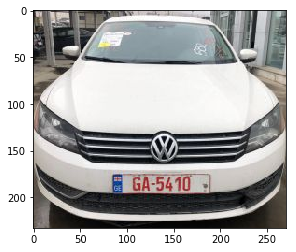

In [95]:
print("The color is{} ".format(predict_color(src)))